## Analysing Wikipedia Book Data

After gathering all of the data about books on Wikipedia, it's time to see what we can find from it! 

### Read in Data

In [1]:
import pandas as pd
import numpy as np

import json

In [2]:
data_path = 'C:/Users/Mosses Ogbonna/Documents/data/found_books_filtered.ndjson'

books = []

with open(data_path, 'r') as fin:
    for l in fin.readlines():
        books.append(json.loads(l))
        
print(f'Found {len(books)} books.')

Found 48148 books.


In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
import pprint

books[2]

['Strangers from the Sky',
 {'name': 'Strangers from the Sky',
  'image': 'Stock_Photo_Strangers_from_the_Sky_bookcover.jpg',
  'caption': 'Cover page of third edition',
  'image_size': '200px',
  'author': 'Margaret Wander Bonanno',
  'audio_read_by': 'George Takei with Leonard Nimoy as voice of Spock',
  'cover_artist': 'Boris Vallejo \n Jerry Vanderstelt (re-release)',
  'country': 'United States',
  'language': 'English',
  'genre': 'Science fiction',
  'published': '* July 1987 (first edition) \n * 1993 (second edition) \n * August 2006 (third edition)',
  'publisher': 'Pocket Books',
  'media_type': 'Print (Paperback)',
  'pages': '* 402 pp (first edition) \n * 402 pp (second edition) \n * 416 pp (third edition)',
  'isbn': '978-0-671-64049-1',
  'isbn_note': '(1st edition) < br / >   (2nd edition) < br / >   (3rd edition)',
  'oclc': '12603784'},
 ['Margaret Wander Bonanno',
  'George Takei',
  'Leonard Nimoy',
  'Boris Vallejo',
  'Jerry Vanderstelt',
  'Science fiction',
  'Po

### Internal Links

First we'll explore the distribution of internal wikilinks. These are links within articles that point to other Wikipedia articles. We collected the titles of every one of these links for each book.

In [4]:
wikilinks = [book[2] for book in books]
wikilinks[2]

['Margaret Wander Bonanno',
 'George Takei',
 'Leonard Nimoy',
 'Boris Vallejo',
 'Jerry Vanderstelt',
 'Science fiction',
 'Pocket Books',
 'Paperback',
 'Margaret Wander Bonanno',
 'Star Trek: The Original Series',
 'Star Trek timeline',
 'First contact (science fiction)',
 'James T. Kirk',
 'Starfleet',
 'PTSD',
 'Leonard McCoy',
 'Spock',
 'mind meld',
 'Starship Enterprise',
 'Gary Mitchell (Star Trek)',
 'Where No Man Has Gone Before',
 'Star Trek: Enterprise',
 'Carbon Creek (Star Trek: Enterprise)',
 'George Takei',
 'Leonard Nimoy',
 'Spock',
 'Category:1987 American novels',
 'Category:Novels based on Star Trek: The Original Series']

In [5]:
wikilink_count = [len(x) for x in wikilinks]

In [6]:
data = pd.DataFrame({'title': [book[0] for book in books], 'wikilink_count': wikilink_count})
data.sort_values('wikilink_count').tail()

,title,wikilink_count
22352,Asimov's Biographical Encyclopedia of Science ...,1767
21491,Timeline of science fiction,1857
32129,Wikipedia:Help desk/Archive 63,1952
28393,Wikipedia:Administrators' noticeboard/Archive281,3212
19887,Wikipedia:Articles for creation/Redirects and ...,3926


This looks like we have some anomalies! We have inadvertently captured articles that clearly are not books, but do mention the **Infobox book** template. Let's see how many of these there are.

In [7]:
potential_anomlies = [book[0] for book in books if 'Wikipedia' in book[0]]
len(potential_anomlies)

30

We'll remove all of these articles.

In [8]:
books = [book for book in books if 'Wikipedia' not in book[0]]
len(books)

48118

In [9]:
wikilinks = [book[2] for book in books]
wikilink_count = [len(x) for x in wikilinks]

pd.options.display.max_colwidth = 100

data = pd.DataFrame({'title': [book[0] for book in books], 'wikilink_count': wikilink_count})
data.sort_values('wikilink_count').tail()

,title,wikilink_count
16873,Harvard Classics,858
47078,Biographical Dictionary of the Extreme Right Since 1890,964
17216,1001 Children's Books You Must Read Before You Grow Up,1075
22331,Asimov's Biographical Encyclopedia of Science and Technology,1767
21470,Timeline of science fiction,1857


It still seems like there are a few anomalies. However, to remove these further, we'd have to go through one at a time and inspect the pages. For now, we can simply leave these in and hope they don't have too great of an impact on the analysis.

In [10]:
from itertools import chain

print(f"There are {len(set(chain(*wikilinks)))} unique wikilinks.")

There are 414108 unique wikilinks.


We can also count the occurence of each Wikilink. This makes use of the **Counter** class in the collections library.

In [11]:
from collections import Counter

wikilink_counts = Counter(chain(*wikilinks))
wikilink_counts['War and Peace']

44

In [12]:
wikilink_counts = sorted(wikilink_counts.items(), key = lambda x: x[1], reverse = True)
wikilink_counts[:10]

[('The New York Times', 7884),
 ('Hardcover', 6786),
 ('Wikipedia:WikiProject Books', 6230),
 ('Paperback', 6204),
 ('Wikipedia:WikiProject Novels', 6195),
 ('Publishers Weekly', 5753),
 ('Kirkus Reviews', 5110),
 ('The Guardian', 4783),
 ('English language', 3898),
 ('Science fiction', 3326)]

    The top wikilinks make a lot of sense. We can search through the wikilink counts for only those books to see what are the most linked to books by other books.

First we'll make a dictionary for mapping books to an index.

In [13]:
book_to_idx = {book[0]: idx for idx, book in enumerate(books)}
len(book_to_idx)

48118

In [14]:
wikilink_books = [x for x in wikilink_counts if x[0] in book_to_idx.keys()]
wikilink_books[:10]

[('The Lord of the Rings', 199),
 ('The Encyclopedia of Science Fiction', 199),
 ('The Discontinuity Guide', 182),
 ('The Federalist Papers', 150),
 ('Discworld', 136),
 ('Encyclopædia Britannica', 106),
 ('Nineteen Eighty-Four', 92),
 ('Dracula', 87),
 ('The Hobbit', 82),
 ("Alice's Adventures in Wonderland", 76)]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## External Links

In [16]:
ex_links = list(chain(*[book[3] for book in books]))
print(f'There are {len(set(ex_links))} unique external links.')

There are 301662 unique external links.


In [17]:
ex_link_counts = sorted(Counter(ex_links).items(), key = lambda x: x[1], reverse = True)
ex_link_counts[:10]

[('https://www.ebsco.com', 664),
 ('http://search.ebscohost.com/login.aspx?direct=true', 209),
 ('http://primocat.bl.uk/F?func=direct', 154),
 ('http://guide.doctorwhonews.net/info.php?detail=ratings', 138),
 ('https://search.ebscohost.com/login.aspx?direct=true', 116),
 ('http://darwin-online.org.uk/content/frameset?viewtype=text', 97),
 ('http://www.ala.org/alsc/awardsgrants/bookmedia/caldecottmedal/caldecotthonors/caldecottmedal',
  85),
 ('http://www.litencyc.com/php/sworks.php?rec=true', 78),
 ('http://docs.newsbank.com/openurl?ctx_ver=z39.88-2004', 74),
 ('https://web.archive.org/web/20190329183744/http://www.ala.org/alsc/awardsgrants/bookmedia/caldecottmedal/caldecotthonors/caldecottmedal',
  70)]

Let's try to get the root of each website in the external links using some string operations.

In [19]:
'http://www.litencyc.com/php/sworks.php?rec=true'.split('//')[-1].split('/')[0]

'www.litencyc.com'

In [20]:
'https://www.ebsco.com'.split('//')[-1].split('/')[0]

'www.ebsco.com'

In [21]:
ex_root = [link.split('//')[-1].split('/')[0] for link in ex_links]
ex_link_counts = sorted(Counter(ex_root).items(), key = lambda x: x[1], reverse = True)
ex_link_counts[:10]

[('books.google.com', 16191),
 ('archive.org', 15959),
 ('www.nytimes.com', 11587),
 ('www.theguardian.com', 7617),
 ('www.publishersweekly.com', 5567),
 ('www.kirkusreviews.com', 5248),
 ('www.jstor.org', 2759),
 ('www.washingtonpost.com', 2740),
 ('www.goodreads.com', 2278),
 ('www.independent.co.uk', 2262)]

In [22]:
def plot_counts(tup, xlabel, n = 10):
    df = pd.DataFrame({'count': [x[1] for x in tup]}, 
                      index = [x[0] for x in tup]).sort_values('count', ascending = False)
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize = (8, 6))
    df['count'].head(n).plot.bar(color = 'r', edgecolor = 'k', linewidth = 2)
    plt.ylabel('count'); plt.title(f'{xlabel.capitalize()} Bar Plot');

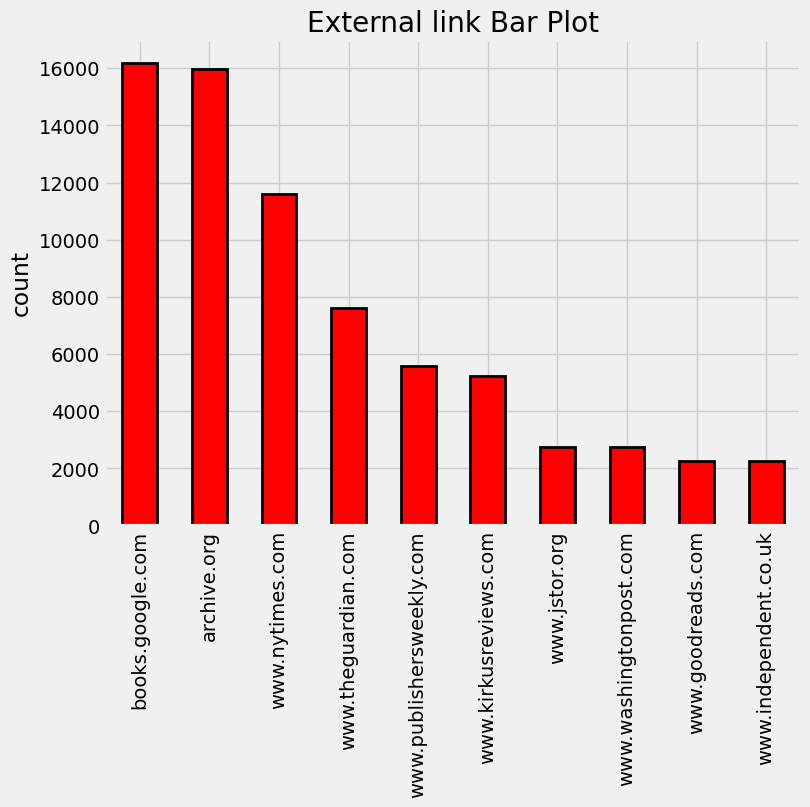

In [23]:
plot_counts(ex_link_counts, 'External Link')

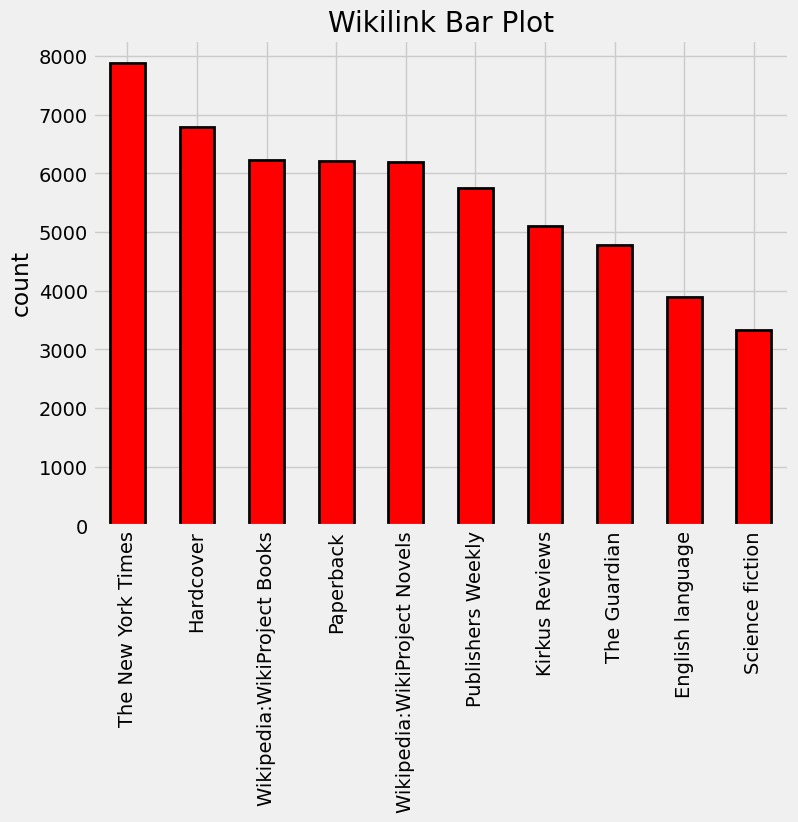

In [24]:
plot_counts(wikilink_counts, 'wikilink')

## Exploring Categories

In [25]:
categories = []

for book in books:
    for link in book[2]:
        if 'Category:' in link:
            categories.append(link[9:])
    
print(f"There are {len(set(categories))} unique categories.")

There are 36800 unique categories.


In [26]:
from collections import Counter

cate_counts = dict(Counter(categories))
cate_count_list = sorted(cate_counts.items(), key = lambda x: x[1], reverse = True)
cate_count_list[:10]

[('English-language books', 2083),
 ('American science fiction novels', 1381),
 ('American novels adapted into films', 1373),
 ('American fantasy novels', 1190),
 ('British novels adapted into films', 1163),
 ('American non-fiction books', 1129),
 ('American young adult novels', 1075),
 ('HarperCollins books', 1054),
 ('Novels set in London', 939),
 ('Doubleday (publisher) books', 785)]

In [27]:
cate_count_list[-10:]

[('Systema Naturae', 1),
 ('Book series introduced in 1735', 1),
 ('1735 in science', 1),
 ('Biological systems', 1),
 ('Books by P. F. Strawson', 1),
 ('1909 Canadian novels', 1),
 ('1915 Canadian novels', 1),
 ('1917 Canadian novels', 1),
 ('Battle of Ia Drang', 1),
 ('Notting Hill', 1)]

(array([3.6668e+04, 9.7000e+01, 2.2000e+01, 4.0000e+00, 1.0000e+00,
        5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 2.0920e+02, 4.1740e+02, 6.2560e+02, 8.3380e+02,
        1.0420e+03, 1.2502e+03, 1.4584e+03, 1.6666e+03, 1.8748e+03,
        2.0830e+03]),
 <BarContainer object of 10 artists>)

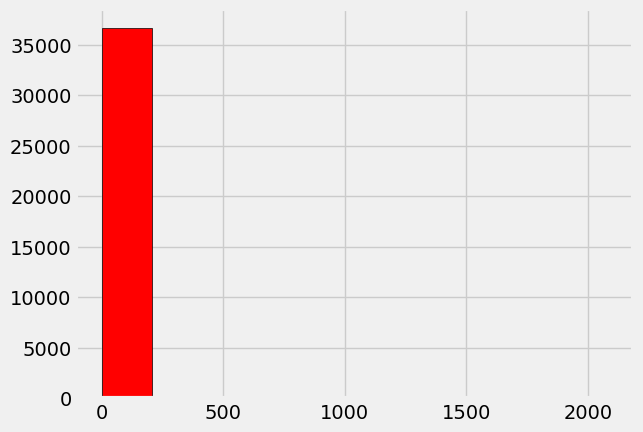

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([x[1] for x in cate_count_list], color = 'red', edgecolor = 'k')

In [29]:
def ecdf(x):
    x = np.sort(x)
    n = len(x)
    y = np.arange(1, n + 1, 1) / n
    return x, y

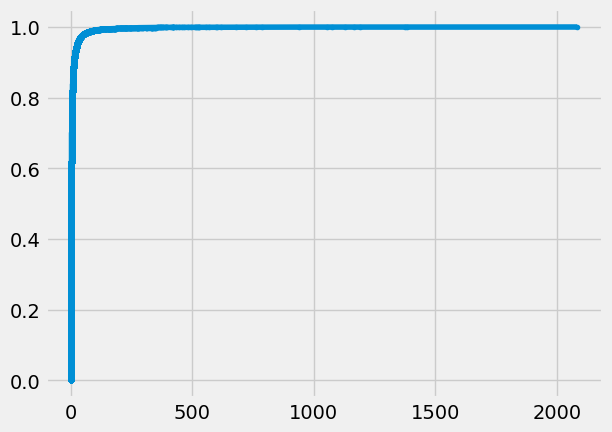

In [30]:
xs, ys = ecdf([x[1] for x in cate_count_list])
plt.plot(xs, ys, marker = '.')

### Exploring Book Attributes

In [31]:
attributes = {}

for book in books:
    for key, value in book[1].items():
        if key in attributes:
            attributes[key].append(value)
        else:
            attributes[key] = [value]

print(f'There are a total of {len(attributes)} attributes.')

There are a total of 143 attributes.


In [32]:
attributes.keys()

dict_keys(['1', 'name', 'image', 'caption', 'author', 'illustrator', 'language', 'genre', 'publisher', 'release_date', 'media_type', 'isbn', 'isbn_note', 'oclc', 'country', 'pages', 'image_size', 'audio_read_by', 'cover_artist', 'published', 'authors', 'series', 'dewey', 'congress', 'title_orig', 'translator', 'pub_date', 'italic title', 'exclude_cover', 'orig_lang_code', 'english_pub_date', 'subject', 'preceded_by', 'followed_by', 'image_caption', 'wikisource', 'border', 'set_in', 'editor', 'external_url', 'english_release_date', 'awards', 'publisher2', 'website', 'release_number', 'alt', 'location', 'external_host', 'ISBN', 'translators', 'award', 'subjects', 'editors', 'notes', 'genres', 'Dimensions', 'native_wikisource', 'nocat_wdimage', 'first', 'last', 'preceded_by_quotation_marks', 'title_working', 'asin', 'followed_by_quotation_marks', 'native_external_host', 'ISBN_note', 'native_external_url', 'printer', 'infoboxwidth', 'illustrators', 'size', 'URL', 'width', 'weight', 'url', 

In [33]:
num_attr = {key: len(values) for key, values in attributes.items()}
num_attr = sorted(num_attr.items(), key = lambda x: x[1], reverse = True)
num_attr[:30]

[('name', 46081),
 ('author', 45490),
 ('image', 44744),
 ('language', 41819),
 ('publisher', 40574),
 ('country', 38437),
 ('genre', 32127),
 ('pages', 32011),
 ('isbn', 30985),
 ('media_type', 30644),
 ('caption', 30207),
 ('release_date', 22587),
 ('pub_date', 17108),
 ('oclc', 15158),
 ('1', 14705),
 ('followed_by', 14045),
 ('preceded_by', 12810),
 ('series', 9698),
 ('subject', 9109),
 ('cover_artist', 8847),
 ('congress', 7652),
 ('published', 6324),
 ('dewey', 6271),
 ('title_orig', 5134),
 ('italic title', 4507),
 ('isbn_note', 3973),
 ('illustrator', 3846),
 ('image_size', 2921),
 ('translator', 2663),
 ('english_pub_date', 1950)]

Let's make a dataframe that has the columns as the attributes and each row is a book. We'll keep only the 100 most common attributes.

In [34]:
num_attr_top = num_attr[:30]

data = pd.DataFrame(columns = ['title'] + [x[0] for x in num_attr_top])
data['title'] = [x[0] for x in books]
data.head()

,title,name,author,image,language,publisher,country,genre,pages,isbn,...,congress,published,dewey,title_orig,italic title,isbn_note,illustrator,image_size,translator,english_pub_date
0,"City of Light, City of Dark",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Koreans (book),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Strangers from the Sky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Prime Directive (novel),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gorbunov and Gorchakov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
book_dict = {book[0]: book[1] for book in books}
book_dict['Animal Farm'].values()

dict_values(['Animal Farm', 'Animal Farm: A Fairy Story', 'Animal Farm - 1st edition.jpg', 'First edition cover', 'George Orwell', 'United Kingdom', 'English', 'Political satire', '17 August 1945 (Secker and Warburg, London, England)', 'Print (hard  &  paperback)', '< !-- First released before ISBN system implemented -- >', '823/.912 20', 'PZ3.O793 An', '3655473', 'Nineteen Eighty-Four', 'Inside the Whale and Other Essays', "Modern Library's 100 Best Novels \n NPR: 100 Best Science Fiction and Fantasy Books \n \n Hugo Award for Best Short Novel (1946) \n Prometheus Award – Hall of Fame (2011)", '92'])

### Conclusion
The analysis of Wikipedia's book data reveals patterns and insights. We observe notable trends in book categories and book attributes. 